<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:** 

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. 
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [2]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    # from going_modular.going_modular import data_loaders, engine
    from going_modular import data_loaders, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    # !git clone https://github.com/mrdbourke/pytorch-deep-learning
    # !mv pytorch-deep-learning/going_modular .
    # !rm -rf pytorch-deep-learning
    # from going_modular.going_modular import data_setup, engine

c:\Users\Tiger\anaconda3\envs\p311Udacity1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data 

In [4]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("../data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

..\data\pizza_steak_sushi directory exists.


### Prepare data

In [44]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [6]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_loaders.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1e02d066190>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [7]:
# Setup the model with pretrained weights and send it to the target device 
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

c:\Users\Tiger\anaconda3\envs\p311Udacity1\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Tiger\anaconda3\envs\p311Udacity1\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [9]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [10]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [11]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_0_results = engine.train_model(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:04<00:19,  4.75s/it]

Epoch: 1 |train_loss: 1.0894 |train_acc:0.4453 | test_loss: 0.9212 | test_acc: 0.5085


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]

[INFO] Total training time: 11.343 seconds


### Make predictions on the entire test dataset with the model

In [12]:
# TODO
len(test_dataloader)

3

In [13]:
from tqdm.auto import tqdm
y_preds = []
model_0.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc = 'testing model 0'):
                    X, y = X.to (device), y.to(device)
                    y_logit = model_0(X)
                    y_pred = torch.softmax(y_logit, dim = 1).argmax(dim =1)
                    y_preds.append(y_pred.cpu()
                     )
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

testing model 0: 100%|██████████| 3/3 [00:00<00:00,  6.95it/s]


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [14]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


In [15]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


In [16]:
len(class_names)

3

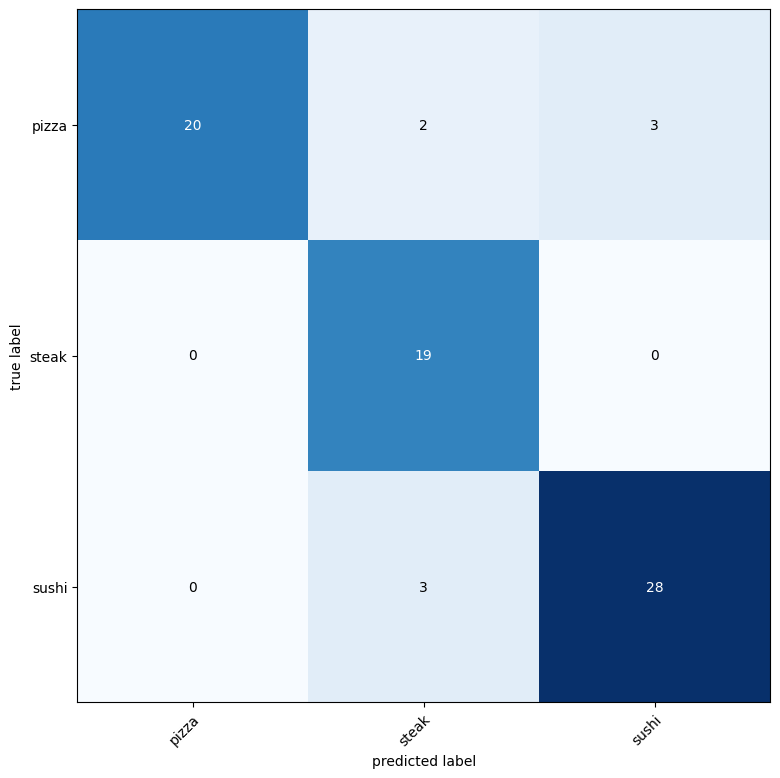

In [17]:
# TODO
from mlxtend.plotting import plot_confusion_matrix
test_truth = torch.cat([y for X, y in test_dataloader])
from torchmetrics import Accuracy, ConfusionMatrix
confmat = ConfusionMatrix(num_classes=len(class_names), task = 'multiclass')
confmat_tensor = confmat(preds= y_pred_tensor,
                          target=test_truth)

fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize = (12, 9)
)

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [18]:
# TODO

# get paths and lables
from PIL import Image
test_path_list = list (test_dir.glob('*/*.jpg'))
class_list = [path.parent.stem for path in test_path_list]
def pred_and_store (test_paths, model, transform, class_names, device):
    test_pred_list = []
    for path in tqdm(test_paths):
        pred_dict = {}
        pred_dict['image_path'] = path
        class_name = path.parent.stem
        pred_dict['class_name'] = class_name
        img = Image.open(path)
        transformed_image = transform(img).unsqueeze(0)
        model.eval()
        with torch.inference_mode():
            pred_logit = model (transformed_image.to(device))
            pred_prob = torch.softmax(pred_logit, dim = 1)
            pred_label = torch.argmax(pred_prob, dim = 1)
            pred_class = class_names[pred_label.cpu()]

            pred_dict['pred_prob'] = pred_prob.unsqueeze(0).max().cpu().item()
            pred_dict ['pred_class'] = pred_class

        pred_dict['correct'] = class_name == pred_class
        test_pred_list.append(pred_dict)

    return test_pred_list

test_pred_dicts = pred_and_store (test_paths = test_path_list,
                                model = model_0,
                                transform=simple_transform,
                                class_names=class_names,
                                device = device)

test_pred_dicts[:5]

100%|██████████| 75/75 [00:01<00:00, 52.71it/s]


[{'image_path': WindowsPath('../data/pizza_steak_sushi/test/pizza/1152100.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7336398959159851,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': WindowsPath('../data/pizza_steak_sushi/test/pizza/1503858.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.6035070419311523,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': WindowsPath('../data/pizza_steak_sushi/test/pizza/1687143.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4691268801689148,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': WindowsPath('../data/pizza_steak_sushi/test/pizza/1925494.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.793107807636261,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': WindowsPath('../data/pizza_steak_sushi/test/pizza/194643.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4041443169116974,
  'pred_class': 'pizza',
  'correct': True}]

In [19]:
import pandas as pd
df_test_pred = pd.DataFrame(test_pred_dicts)
df_top_5_most_wrong = df_test_pred.sort_values(by=['correct', 'pred_prob'], ascending=[True, False]).head(5) 
df_top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
70,..\data\pizza_steak_sushi\test\sushi\684266.jpg,sushi,0.547907,steak,False
24,..\data\pizza_steak_sushi\test\pizza\971934.jpg,pizza,0.454285,sushi,False
44,..\data\pizza_steak_sushi\test\sushi\1172255.jpg,sushi,0.447456,steak,False
12,..\data\pizza_steak_sushi\test\pizza\2508636.jpg,pizza,0.428669,sushi,False
13,..\data\pizza_steak_sushi\test\pizza\2871261.jpg,pizza,0.424974,steak,False


### Show it 

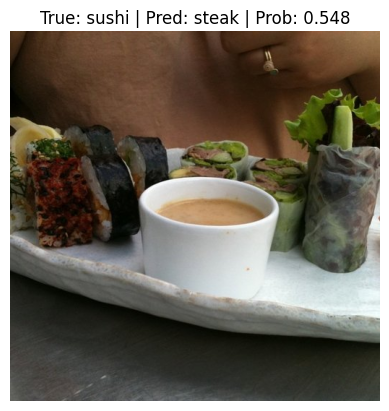

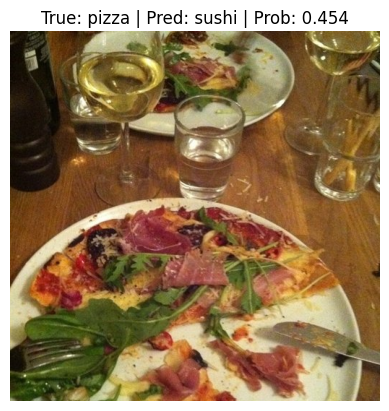

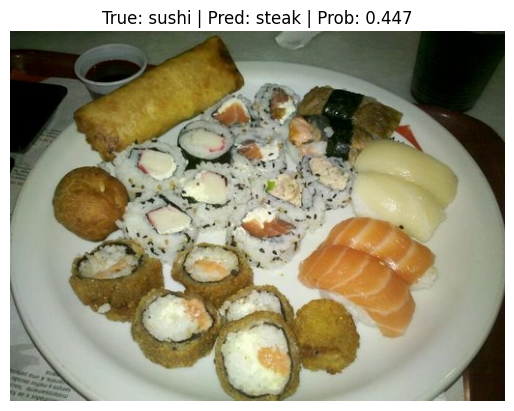

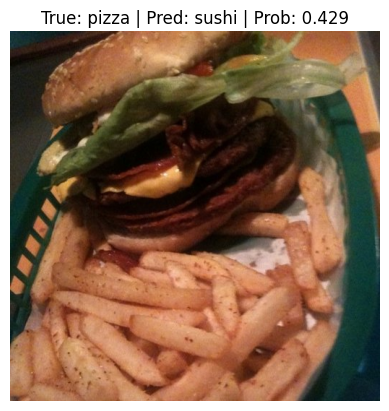

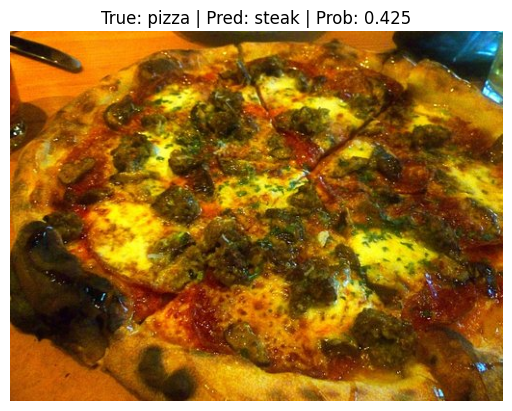

In [20]:
import torchvision
import matplotlib.pyplot as plt
for index, row in df_top_5_most_wrong.iterrows():
    # row = row['class_name']
    image_path = row['image_path']
    true_label = row ['class_name']
    pred_prob = row ['pred_prob']
    pred_class = row ['pred_class']
    img = torchvision.io.read_image(str(image_path))
    plt.figure()
    plt.imshow (img.permute (1, 2, 0))
    plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
    plt.axis(False);

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [22]:
# TODO: Get an image of pizza/steak/sushi
import random
rand_img_list =[random.choice(test_path_list)]
rand_class = [path.parent.stem for path in rand_img_list] 
# rand_img, rand_class
read_pred_dict = pred_and_store (test_paths = rand_img_list,
                                model = model_0,
                                transform=simple_transform,
                                class_names=class_names,
                                device = device)
# img_path = list(random.choice (test_path_list))
# img_path
read_pred_dict

100%|██████████| 1/1 [00:00<00:00, 20.31it/s]


[{'image_path': WindowsPath('../data/pizza_steak_sushi/test/steak/100274.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9096090197563171,
  'pred_class': 'steak',
  'correct': True}]

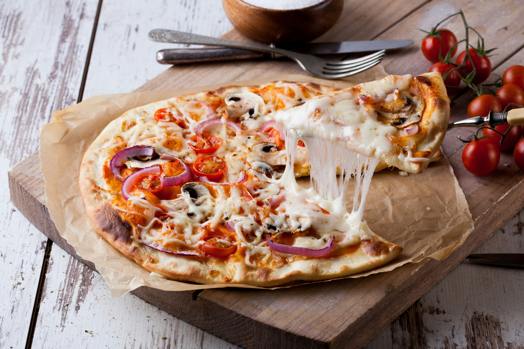

In [23]:
# do the above with unsplash
# Create the directory only if it does not exist
import os
import subprocess

import os
import shutil

# Create the directory only if it does not exist
if not os.path.exists('data/unsplash'):
    os.makedirs('data/unsplash')

# Download the file only if it does not already exist
file_path = 'data/unsplash/photo-1588315029754-2dd089d39a1a'
if not os.path.isfile(file_path):
    import requests
    url = 'https://images.unsplash.com/photo-1588315029754-2dd089d39a1a'
    response = requests.get(url)
    with open(file_path, 'wb') as file:
        file.write(response.content)

# Copy and rename the file only if the destination file does not already exist
new_file_path = 'data/unsplash/pizza.jpg'
if not os.path.isfile(new_file_path):
    shutil.copy(file_path, new_file_path)
    
from PIL import Image
with Image.open ('data/unsplash/pizza.jpg') as img:
    (width, height) = (img.width//10, img.height//10)
    img_resized = img.resize((width, height))

img_resized


In [24]:
from typing import Tuple, Dict, List
def pred_and_plot_image (model: torch.nn.Module,
                         image_path: str,
                         class_names: List[str],
                         image_size: Tuple[int, int] = (224, 224),
                         transform: torchvision.transforms = None,
                         device: torch.device = device):
    
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize (mean = [0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
        ])
    
    model.to(device)

    model.eval()
    
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)


        target_image_pred = model(transformed_image.to(device))

        target_image_pred = model (transformed_image.to(device))

    target_iamge_pred_probs = torch.softmax(target_image_pred, dim = 1)

    target_image_pred_label = torch.argmax(target_iamge_pred_probs, dim = 1)

    plt.figure ()
    plt.imshow(img)
    plt.title (f'Pred: {class_names[target_image_pred_label]} | Prob: {target_iamge_pred_probs.max():.3f}')
    plt.axis(False)

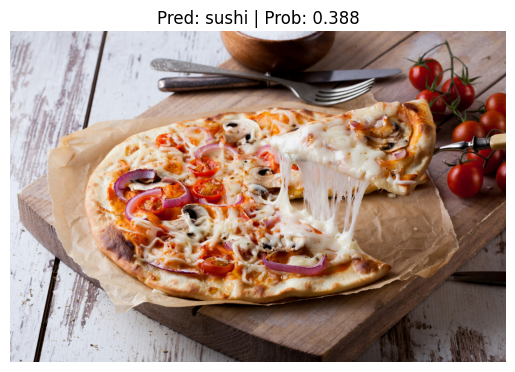

In [59]:
custom_image_path = 'data/unsplash/pizza.jpg'
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names = class_names)

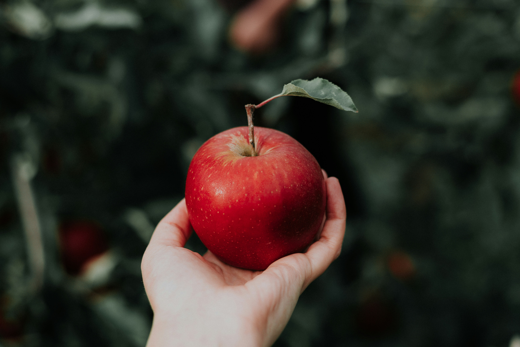

In [25]:
# TODO: Get an image of not pizza/steak/sushi
# do the above with unsplash
# Create the directory only if it does not exist
import os
import subprocess

import os
import shutil

# Create the directory only if it does not exist
if not os.path.exists('data/unsplash'):
    os.makedirs('data/unsplash')

# Download the file only if it does not already exist
file_path = 'data/unsplash/photo-1570913149827-d2ac84ab3f9a'
if not os.path.isfile(file_path):
    import requests
    url = 'https://images.unsplash.com/photo-1570913149827-d2ac84ab3f9a'
    response = requests.get(url)
    with open(file_path, 'wb') as file:
        file.write(response.content)

# Copy and rename the file only if the destination file does not already exist
new_file_path = 'data/unsplash/apple.jpg'
if not os.path.isfile(new_file_path):
    shutil.copy(file_path, new_file_path)
    
from PIL import Image
with Image.open ('data/unsplash/apple.jpg') as img:
    (width, height) = (img.width//10, img.height//10)
    img_resized = img.resize((width, height))

img_resized


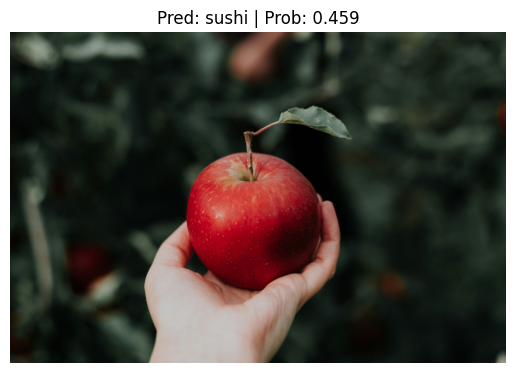

In [27]:
custom_image_path = 'data/unsplash/apple.jpg'
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names = class_names)

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [28]:
# TODO: Recreate a new model 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_1 = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [29]:
# TODO: Train the model for 10 epochs
for param in model_1.features.parameters():
    param.requires_grad = False

torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model_1.classifier=torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features = 1280,
                    out_features=output_shape,
                    bias=True).to(device) 
)

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# for param in model_1.features.parameters():
#     param.requires_grad = False

In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr = 0.001)

In [33]:
data_path = Path("../data")
image_path = data_path / "pizza_steak_sushi_20_percent"
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"
train_dir_20_percent, test_dir_20_percent

(WindowsPath('../data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('../data/pizza_steak_sushi_20_percent/test'))

In [35]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_loaders.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1e0aada5790>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_1_results = engine.train_model(model=model_1,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\Tiger\anaconda3\envs\p311Udacity1\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
 20%|██        | 1/5 [00:04<00:19,  4.93s/it]

Epoch: 1 |train_loss: 0.9822 |train_acc:0.5333 | test_loss: 0.7290 | test_acc: 0.9534


100%|██████████| 5/5 [00:23<00:00,  4.74s/it]

[INFO] Total training time: 23.713 seconds


In [76]:
max(model_1_results['test_acc']), min(model_1_results['test_loss'])

(0.9318181818181819, 0.25123169720172883)

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb). 


### Get 20% data

## Done in previous section alread

In [ ]:
# import os
# import requests
# import zipfile

# from pathlib import Path

# # Setup path to data folder
# data_path = Path("data/")
# image_path = data_path / "pizza_steak_sushi_20_percent"
# image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# # If the image folder doesn't exist, download it and prepare it... 
# if image_path.is_dir():
#     print(f"{image_path} directory exists.")
# else:
#     print(f"Did not find {image_path} directory, creating one...")
#     image_path.mkdir(parents=True, exist_ok=True)
    
#     # Download pizza, steak, sushi data
#     with open(data_path / image_data_zip_path, "wb") as f:
#         request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
#         print("Downloading pizza, steak, sushi data...")
#         f.write(request.content)

#     # Unzip pizza, steak, sushi data
#     with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
#         print("Unzipping pizza, steak, sushi 20% data...") 
#         zip_ref.extractall(image_path)

#     # Remove .zip file
#     os.remove(data_path / image_data_zip_path)

# # Setup Dirs
# train_dir_20_percent = image_path / "train"
# test_dir_20_percent = image_path / "test"

# train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [32]:
data_path = Path("../data")
image_path = data_path / "pizza_steak_sushi_20_percent"
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"
train_dir_20_percent, test_dir_20_percent

(WindowsPath('../data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('../data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [63]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [65]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_loaders.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1b321fbdcd0>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [79]:
# TODO
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)



model_0.classifier=torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features = 1280,
                    out_features=output_shape,
                    bias=True)).to(device) 

c:\Users\Tiger\anaconda3\envs\p311Udacity1\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Tiger\anaconda3\envs\p311Udacity1\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Train a model with 20% of the data

In [ ]:
# TODO

In [37]:
# TODO 
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model_2 = torchvision.models.efficientnet_b2(weights=weights).to(device)



Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\Tiger/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:05<00:00, 7.30MB/s]


In [39]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_2, 
        input_size=(32, 3, 288, 288), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

c:\Users\Tiger\anaconda3\envs\p311Udacity1\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 288, 288]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 288, 288]    [32, 1408, 9, 9]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 288, 288]    [32, 32, 144, 144]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 288, 288]    [32, 32, 144, 144]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 144, 144]   [32, 32, 144, 144]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 144, 144]   [32, 32, 144, 144]   --                   --
│    └─Sequential (1)                                        [32, 32, 144, 144]   [32, 16, 144

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_2.features.parameters():
    param.requires_grad = False

In [48]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

for param in model_2.features.parameters():
    param.requires_grad = False

model_2.classifier=torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features = 1408,
                    out_features=output_shape,
                    bias=True)).to(device) 


In [49]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_2, 
        input_size=(32, 3, 288, 288), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 288, 288]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 288, 288]    [32, 1408, 9, 9]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 288, 288]    [32, 32, 144, 144]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 288, 288]    [32, 32, 144, 144]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 144, 144]   [32, 32, 144, 144]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 144, 144]   [32, 32, 144, 144]   --                   --
│    └─Sequential (1)                                        [32, 32, 144, 144]   [32, 

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr = 0.001)

In [52]:
# Create a transforms pipeline
simple_b2_transform = transforms.Compose([
    transforms.Resize((288, 288)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])



In [53]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_loaders.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_b2_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1e0a89d39d0>,
 ['pizza', 'steak', 'sushi'])

In [55]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_2_results = engine.train_model(model=model_2,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:04<00:19,  4.75s/it]

Epoch: 1 |train_loss: 0.3465 |train_acc:0.9250 | test_loss: 0.3464 | test_acc: 0.9597


100%|██████████| 5/5 [00:23<00:00,  4.71s/it]

[INFO] Total training time: 23.556 seconds
